**Imports for Loading**

In [5]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing helpers
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**1. Identify The Problem**

There is a significant problem with the immediate propagation of false or misinformed messages on applications such as WhatsApp, SMS and social media. They consist of short, informal messages that can hardly be found by applying the traditional methods and result in missed threats or falsely identified flags. With increased digital communication, unrestricted proliferation of incorrect messages may lead to widespread confusion in the population, panic, manipulation, and loss of money and, therefore, timely and correct identification is required.


**2. Data Understanding**

**2.1 Data Collection**

In [6]:
# Data Loading
data_fake = pd.read_csv("Fake.csv", engine='python', on_bad_lines='skip')
data_real = pd.read_csv("True.csv", engine='python', on_bad_lines='skip' )

In [7]:
# Add label to the data
data_fake['label'] = 'FAKE'
data_real['label'] = 'REAL'

In [8]:
# Merge the Datasets
dataset = pd.concat([data_fake, data_real], ignore_index=True)

**2.2 Initial Overview**

In [9]:
# Quick look
print(dataset.shape)
display(dataset.head())


(4866, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE


In [10]:
#Data Types and nulls
print(dataset.info())
print(dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4866 entries, 0 to 4865
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4866 non-null   object
 1   text     4866 non-null   object
 2   subject  4866 non-null   object
 3   date     4866 non-null   object
 4   label    4866 non-null   object
dtypes: object(5)
memory usage: 190.2+ KB
None
title      0
text       0
subject    0
date       0
label      0
dtype: int64


**2.3 Summary Statistics**

In [11]:
# For numeric columns (we'll add a few numeric features later)
print(dataset.describe(include='all'))

                                                    title  \
count                                                4866   
unique                                               4851   
top     Trump warns 'rogue regime' North Korea of grav...   
freq                                                    2   

                                                     text       subject  \
count                                                4866          4866   
unique                                               4853             2   
top     WASHINGTON (Reuters) - President Donald Trump ...  politicsNews   
freq                                                    2          2479   

                      date label  
count                 4866  4866  
unique                 461     2  
top     November 30, 2017   REAL  
freq                    45  2479  


In [12]:
# Class distribution
print(dataset['label'].value_counts())

label
REAL    2479
FAKE    2387
Name: count, dtype: int64


**2.4 Visualize the Key aspects**

In [13]:
# Compute combined text and text length first
dataset['content'] = dataset['title'].fillna('') + " " + dataset['text'].fillna('')
dataset['textLength'] = dataset['content'].apply(lambda x: len(str(x)))


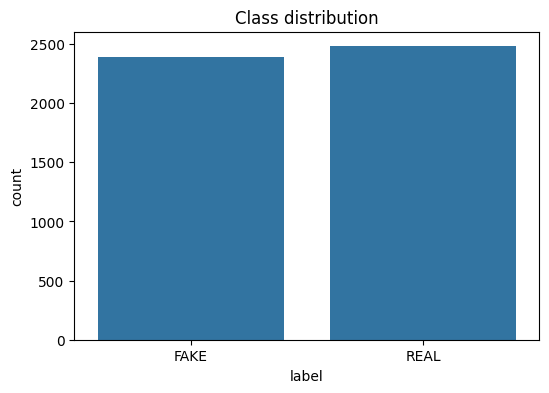

In [14]:
# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=dataset, x='label')
plt.title('Class distribution')
plt.show()

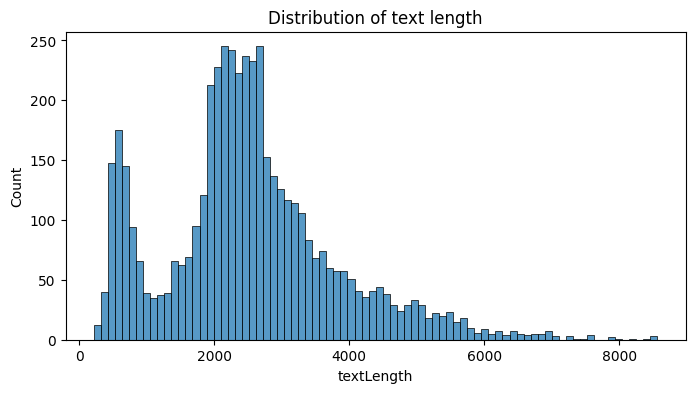

In [15]:
# text length histogram
plt.figure(figsize=(8,4))
sns.histplot(dataset['textLength'], bins=80)
plt.title('Distribution of text length')
plt.show()

**2.5 Identify issues**

In [16]:
# missing values per column
print(dataset.isnull().sum())

title         0
text          0
subject       0
date          0
label         0
content       0
textLength    0
dtype: int64


In [17]:
# duplicates (on content)
print("Duplicates:", dataset['content'].duplicated().sum())

Duplicates: 11


In [18]:
# extreme text length outliers
q1 = dataset['textLength'].quantile(0.01)
q99 = dataset['textLength'].quantile(0.99)
print("1% of length:", q1 )
print("99% of length:", q99)

1% of length: 415.6
99% of length: 6450.850000000004


In [19]:
# show a few very long entries
display(dataset[dataset['textLength'] > q99].head())

,title,text,subject,date,label,content,textLength
65,Principles Over Power: Why Republicans Need T...,"Over the last few weeks, I ve watched as the l...",News,"November 25, 2017",FAKE,Principles Over Power: Why Republicans Need T...,7025
1162,How The GOP Became The Party Of White Suprema...,The Republican Party has always had a problem ...,News,"June 13, 2017",FAKE,How The GOP Became The Party Of White Suprema...,7624
1350,Dear President Moron: Since You Don’t Seem To...,Donald Trump doesn t like NATO. Much like the ...,News,"May 26, 2017",FAKE,Dear President Moron: Since You Don’t Seem To...,8367
2421,As Republicans aim to ride economy to election...,"KING OF PRUSSIA, Pennsylvania/WASHINGTON (Reu...",politicsNews,"December 22, 2017",REAL,As Republicans aim to ride economy to election...,6848
2453,"In Georgia, battle of the 'Staceys' tests Demo...",ATLANTA (Reuters) - The two Democratic candida...,politicsNews,"December 20, 2017",REAL,"In Georgia, battle of the 'Staceys' tests Demo...",8241


**3. Data PrePrecessing**

In [20]:
import html
import re
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # remove html escapes
    text = html.unescape(text)
    # remove urls
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # keep letters/numbers/space
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    # lowercase
    text = text.lower()
    # tokenize using regex
    tokens = re.findall(r'\b\w+\b', text)
    tokens = [t for t in tokens if t not in STOPWORDS and not t.isdigit()]
    return ' '.join(tokens)

In [21]:
# Apply (may be slow on millions of rows; sample or batch)
dataset['clean_text'] = dataset['content'].apply(clean_text)

**3.1 remove incorrect data**

In [22]:
# Drop rows where clean_text is empty
dataset['clean_text'] = dataset['clean_text'].astype(str)
dataset = dataset[dataset['clean_text'].str.strip() != ""].copy()


**3.2 Handle Duplicates**

In [23]:
dataset = dataset.drop_duplicates(subset=['clean_text']).reset_index(drop=True)

**3.3 Handling missing Values**

In [24]:
# For Subject
dataset['subject'] = dataset['subject'].fillna(dataset['subject'].mode()[0])

In [25]:
#For Numeric
dataset['textLength'] = dataset['textLength'].fillna(dataset['textLength'].median())

**3.4 Binning**

In [26]:
# Equal-width bins
bins = [0, 50, 200, 500, 1000, dataset['textLength'].max()+1]
labels = ['very_short', 'short', 'medium', 'long', 'very_long']
dataset['length_bin'] = pd.cut(dataset['textLength'], bins=bins, labels=labels, include_lowest=True)

In [27]:
# Replace bin values with bin mean
bin_mean = dataset.groupby('length_bin')['textLength'].transform('mean')
dataset['length_bin_mean'] = bin_mean

/tmp/ipython-input-3186026227.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_mean = dataset.groupby('length_bin')['textLength'].transform('mean')


**3.5 regression**

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [35]:
# Vectorize a sample
sample = dataset.sample(n=min(1000, len(dataset)), random_state=42)
vect = TfidfVectorizer(max_features=5000)
X = vect.fit_transform(sample['clean_text'])

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10) # Added n_init to suppress future warning
sample['cluster'] = kmeans.fit_predict(X)

In [32]:
# Show distribution per cluster
print(sample['cluster'].value_counts())

cluster
4    1786
1    1523
2     638
3     339
0     303
5     265
Name: count, dtype: int64


**4. Reduction**

**4.1 Dimensionality reduction**

In [36]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# create TF-IDF for full
vect = TfidfVectorizer(max_df=0.7, min_df=5, max_features=20000)
X_tfidf = vect.fit_transform(dataset['clean_text'].sample(n=1000, random_state=42))  # sample for speed

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

**4.2 Attribute subset selection**

In [39]:
from sklearn.feature_selection import SelectKBest, chi2

# For selection we need numeric X and y
y_sample = (dataset['label'].sample(n=3882, random_state=42) == 'FAKE').astype(int)
X_sample = vect.transform(dataset['clean_text'].sample(n=3882, random_state=42))

selector = SelectKBest(chi2, k=2000)
X_selected = selector.fit_transform(X_sample, y_sample)

**4.3 Numerosity reduction**

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified subsampling: keep 80% for training
df_train, df_test = train_test_split(dataset, train_size=0.8, stratify=dataset['label'], random_state=42)
print("Training set size:", df_train.shape[0])
print("Testing set size:", df_test.shape[0])
print("\nTraining set label distribution:\n", df_train['label'].value_counts())
print("\nTesting set label distribution:\n", df_test['label'].value_counts())

**5. Transformation**

**5.1 Normalize numeric features**

In [40]:
from sklearn.preprocessing import StandardScaler

# Example numeric features
dataset['word_count'] = dataset['clean_text'].apply(lambda x: len(x.split()))
dataset['avg_word_len'] = dataset['clean_text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)

scaler = StandardScaler()
dataset[['word_count_s', 'avg_word_len_s']] = scaler.fit_transform(dataset[['word_count', 'avg_word_len']])

**5.2 Feature engineering**

In [41]:
# stopword count
dataset['stopword_count'] = dataset['content'].apply(lambda x: sum(1 for w in str(x).split() if w.lower() in STOPWORDS))


In [42]:
# punctuation count
dataset['punct_count'] = dataset['content'].apply(lambda x: sum(1 for c in str(x) if c in string.punctuation))


In [43]:
# uppercase ratio
dataset['upper_ratio'] = dataset['content'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1))


**5.3 Discretization**

In [44]:
#  discretize word_count into 4 bins
dataset['word_count_bin'] = pd.qcut(dataset['word_count'], q=4, labels=False)

**5.4 Concept hierarchy generation**

In [45]:
# Example mapping
mapping = {
    'Politics': 'News',
    'World': 'News',
    'Health': 'Health',
    'Science': 'Science',
    'Tech': 'Technology',
    'Business': 'Business'
}

# Create 'subject_top' column in the dataset DataFrame
dataset['subject_top'] = dataset['subject'].map(mapping).fillna('Other')

**6. Save Cleaned Data**

In [46]:
# Keep columns needed for modeling
cols_to_save = ['title', 'clean_text', 'label', 'textLength', 'word_count', 'avg_word_len',
                'stopword_count', 'punct_count', 'upper_ratio', 'subject_top']
df_model = dataset[cols_to_save].copy()

df_model.to_csv("cleaned_Dataset.csv", index=False)
print("Saved:", df_model.shape)

Saved: (4854, 10)


In [47]:
# Download The Cleaned Dataset
from google.colab import files
files.download("cleaned_Dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>